# Monte Carlo Simulations with the Efficient Frontier



In [1]:
# library imports

import re
from io import StringIO
from datetime import datetime, timedelta
import requests
import pandas as pd
import numpy as np


In [2]:
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf

def get_historical_data(tickers):
    """
    This function returns a pd dataframe with all of the adjusted closing information
    """
    data = yf.download(
        tickers=tickers,
        start="2020-04-01",
        end="2025-04-01",
        interval="1d",
        auto_adjust=False,
        prepost=False,
    )
    
    # Keep only Adjusted Close prices and transpose to match the image format
    if len(tickers) == 1:
        data = data[['Adj Close']].rename(columns={'Adj Close': tickers[0]})
    else:
        data = data['Adj Close']
    
    return data

ticks = ["INTC", "QCOM", "MSFT", "SONO", "1347.HK", "0700.HK", "NVDA", "1810.HK", "2454.TW","1211.HK","9888.HK","0992.HK","0981.HK","2382.HK"]
d = get_historical_data(ticks)

# Format the output to match the image
pd.set_option('display.float_format', '{:.6f}'.format)
print(d.shape)
d.head()

[*********************100%***********************]  14 of 14 completed


(1298, 14)


Ticker,0700.HK,0981.HK,0992.HK,1211.HK,1347.HK,1810.HK,2382.HK,2454.TW,9888.HK,INTC,MSFT,NVDA,QCOM,SONO
Date,,,,,,,,,,,,,,
2020-04-01,336.079529,12.140000,3.196146,37.133709,13.781777,10.200000,100.721458,241.823059,NaN,45.988293,145.596451,6.054444,59.136017,8.040000
2020-04-02,340.926788,12.460000,3.196146,38.404072,14.317185,10.380000,103.908241,NaN,NaN,48.177792,148.611557,6.363307,61.038410,7.980000
2020-04-03,337.874786,12.180000,3.172412,37.817757,13.841268,10.260000,102.749413,NaN,NaN,47.982777,147.242798,6.075367,58.534782,7.990000
2020-04-06,342.363037,12.780000,3.204057,38.501789,15.090551,10.500000,106.225883,246.891190,NaN,51.794453,158.192963,6.685369,63.667675,8.690000
2020-04-07,347.928467,13.280000,3.346460,40.065319,15.328510,10.480000,112.020035,251.235336,NaN,51.767853,156.489120,6.451979,65.264969,8.860000


In [3]:
# saving the most recent year data such that we can compare...
# Called dT (DataTest)

dT = d.iloc[d.shape[0]-252:,:] # Data test

# Update the "Training" or "data full"
d = d.iloc[:d.shape[0]-252,:] # Data Train for the Simulation

print("Testing Data dimensions:",dT.shape)
print("Training Data dimensions:",d.shape)

Testing Data dimensions: (252, 14)
Training Data dimensions: (1046, 14)


# Understanding Returns

In [4]:
from scipy import stats
expected_returns_a = d.pct_change() # Daily returns from trading day to day...
expected_return_a_columns = ticks # Setting the Column names
expected_returns_aA = pd.DataFrame(expected_returns_a.mean()*250) # Annualizing the average rate of return
expected_returns_aA = expected_returns_aA.T # Transpace the values
dar = d.pct_change().iloc[1:,:]+1 # dar = portfolio returns for each period (in this case day to day)
# 4 is the number of years I am working with (Earlier took out a year for training purposes)
gar = pd.DataFrame(np.prod(dar)**(1/float(4))-1)
print(gar)
full_return_annual = (pd.concat([expected_returns_aA.T, gar], axis=1)) 

full_return_annual.columns = ['Average Arithmetic Returns', 'Average Geometric Returns']
print("Expected Annual Returns", expected_returns_aA)
print("dar", dar)
print("Full Annual Returns", full_return_annual)


                0
Ticker           
0700.HK -0.018801
0981.HK  0.048998
0992.HK  0.273940
1211.HK  0.538863
1347.HK  0.028936
1810.HK  0.119128
2382.HK -0.204217
2454.TW  0.475176
9888.HK -0.202373
INTC    -0.054096
MSFT     0.303282
NVDA     0.947037
QCOM     0.297308
SONO     0.221175
Expected Annual Returns Ticker  0700.HK  0981.HK  0992.HK  1211.HK  1347.HK  1810.HK   2382.HK  \
0      0.065796 0.182438 0.315264 0.555965 0.228441 0.212265 -0.079784   

Ticker  2454.TW   9888.HK     INTC     MSFT     NVDA     QCOM     SONO  
0      0.438091 -0.137824 0.013672 0.291221 0.763066 0.321189 0.341305  
dar Ticker      0700.HK  0981.HK  0992.HK  1211.HK  1347.HK  1810.HK  2382.HK  \
Date                                                                        
2020-04-02 1.014423 1.026359 1.000000 1.034211 1.038849 1.017647 1.031640   
2020-04-03 0.991048 0.977528 0.992574 0.984733 0.966759 0.988439 0.988848   
2020-04-06 1.013284 1.049261 1.009975 1.018088 1.090258 1.023392 1.033834   
2020

# Equation Utilized

## Measuring the Adjusted Risk of Return
Measures the risk adjusted rate of return of a portfolio

$$ Sharpe\ Ratio= \frac{R_p - R_f}{\sigma_p} $$

$\sigma_p$ = Standard Deviation of Portfolio <br>
$R_p$ = Return of Portfolio <br>
$R_f$ = Return of Risk Free Instrument <br>
Rule of Thumb: Sharpe ratio < 1 sub-optimal... There is most likely a better option
Sharpe Ratio > 1 is acceptable <br>
Sharpe Ratio > 2 is very good <br>
Sharpe Ratio > 3 is excellent! <br>

## Volatility
$$ \sum_{i=0}^{N} \sum_{j=0}^{N} \sigma_{ij} X_i X $$
$X$ = Weights in Portfolio <br>
$\sigma_{ij}$ = Variance - Covariance Matrix

## Expected Return
$$ \sum_{i=0}^{N} X_i \mu_i $$
$X$ = Weights in Portfolio <br>
$\mu_i$ = Arithmetric Average Rate of Return for $i^{th}$ security

In [7]:
# storing lists that retain returns, volatility, and weights of the simulated portfolios
portfolio_returns = []
portfolio_volatility = []
sharpe_ratio = []

# This is what is going to be randomized
stock_weights = []

# Number of Individual securities that will be part of portfolio
num_assets = len(ticks)  
# Number of simulated iterations
num_portfolios = 10000

# Getting the covariance matrix
# Gets a percentage change one day to the next
daily_returns = d.pct_change()
# Converting daily retuns to annual returns (standardizing to a year)
annual_returns = (daily_returns.mean() * 250) + 1

# Obtaining the covariance of annual
cov_daily = daily_returns.cov()
cov_annual = cov_daily * 250

print(annual_returns)

Ticker
0700.HK   1.065796
0981.HK   1.182438
0992.HK   1.315264
1211.HK   1.555965
1347.HK   1.228441
1810.HK   1.212265
2382.HK   0.920216
2454.TW   1.438091
9888.HK   0.862176
INTC      1.013672
MSFT      1.291221
NVDA      1.763066
QCOM      1.321189
SONO      1.341305
dtype: float64


In [8]:
# Setting seed of interpretability
np.random.seed(3)
# Filling in the lists with a simulated return, risk, and a given weight
# num_portfolios
for i in range (num_portfolios):
    # Randomly generating weights for each stock in the portfolio
    weights = np.random.random(num_assets)
    # Normalizing the weights to sum to 1
    weights /= np.sum(weights)
    returns = (np.dot(weights, (annual_returns)))
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    """
    sharpe ratio: This calculates the risk adjusted return
    It suggests that adding assets to a portfolio that have low correlation can decrease portfolio risk without
    sacrificing return
    """
    sharpe = ((returns-1) / volatility)

    sharpe_ratio.append(sharpe)
    portfolio_returns.append(returns-1)
    portfolio_volatility.append(volatility)
    stock_weights.append(weights)

In [9]:
# Starting the portfolio values
portfolio = {
    'Returns': portfolio_returns,
    'Volatility': portfolio_volatility,
    'Sharpe Ratio': sharpe_ratio}

# Add an additional entry to the portfolio such that each individual weight is incorporated for its corresponding company
for counter,symbol in enumerate(ticks):
    portfolio[symbol+'Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)
df

,Returns,Volatility,Sharpe Ratio,INTCWeight,QCOMWeight,MSFTWeight,SONOWeight,1347.HKWeight,0700.HKWeight,NVDAWeight,1810.HKWeight,2454.TWWeight,1211.HKWeight,9888.HKWeight,0992.HKWeight,0981.HKWeight,2382.HKWeight
0,0.275223,0.291157,0.945272,0.090452,0.116293,0.047773,0.083888,0.146640,0.147190,0.020624,0.034034,0.008452,0.072390,0.004906,0.075021,0.106603,0.045733
1,0.297159,0.262416,1.132400,0.113626,0.099278,0.004030,0.093900,0.043560,0.069746,0.047639,0.116463,0.074006,0.026357,0.091513,0.131111,0.051476,0.037294
2,0.223666,0.289522,0.772537,0.049330,0.119059,0.124096,0.085492,0.114793,0.107535,0.048061,0.011725,0.083080,0.070928,0.045972,0.028615,0.051688,0.059625
3,0.287587,0.269165,1.068442,0.050462,0.054690,0.085783,0.161287,0.109880,0.053133,0.052101,0.085209,0.038499,0.037744,0.096344,0.016349,0.090637,0.067882
4,0.253292,0.267569,0.946641,0.100148,0.105675,0.097799,0.097529,0.052870,0.094551,0.048093,0.081058,0.046106,0.062994,0.008707,0.034342,0.137496,0.032631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.268133,0.263386,1.018022,0.069953,0.037780,0.089271,0.091708,0.080242,0.051276,0.114583,0.101024,0.041179,0.050684,0.039186,0.068321,0.081077,0.083716
9996,0.243695,0.292147,0.834154,0.061325,0.101368,0.122761,0.022867,0.063206,0.149963,0.042752,0.030229,0.155028,0.047303,0.009479,0.156249,0.020323,0.017148
9997,0.285946,0.261864,1.091966,0.015070,0.085614,0.119902,0.051522,0.088944,0.021571,0.057344,0.009332,0.020874,0.118064,0.014809,0.102368,0.160420,0.134165
9998,0.210747,0.310875,0.677917,0.089677,0.122866,0.019224,0.143987,0.059144,0.134160,0.026259,0.007627,0.153303,0.056414,0.004058,0.023448,0.009157,0.150677


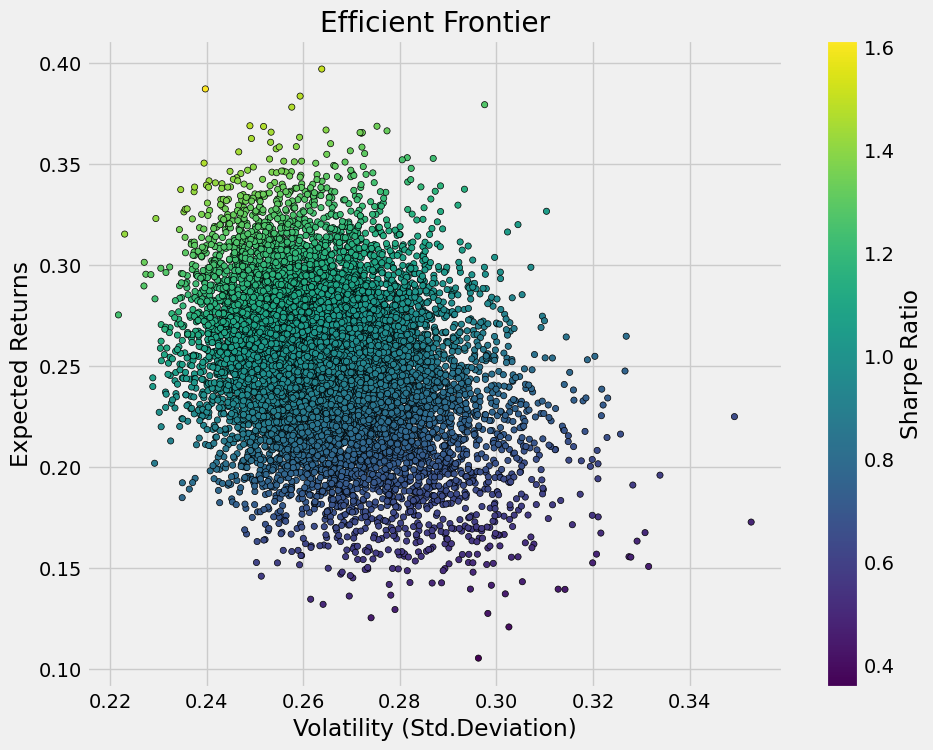

In [10]:
# Plotting the efficient frontier
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='viridis', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std.Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

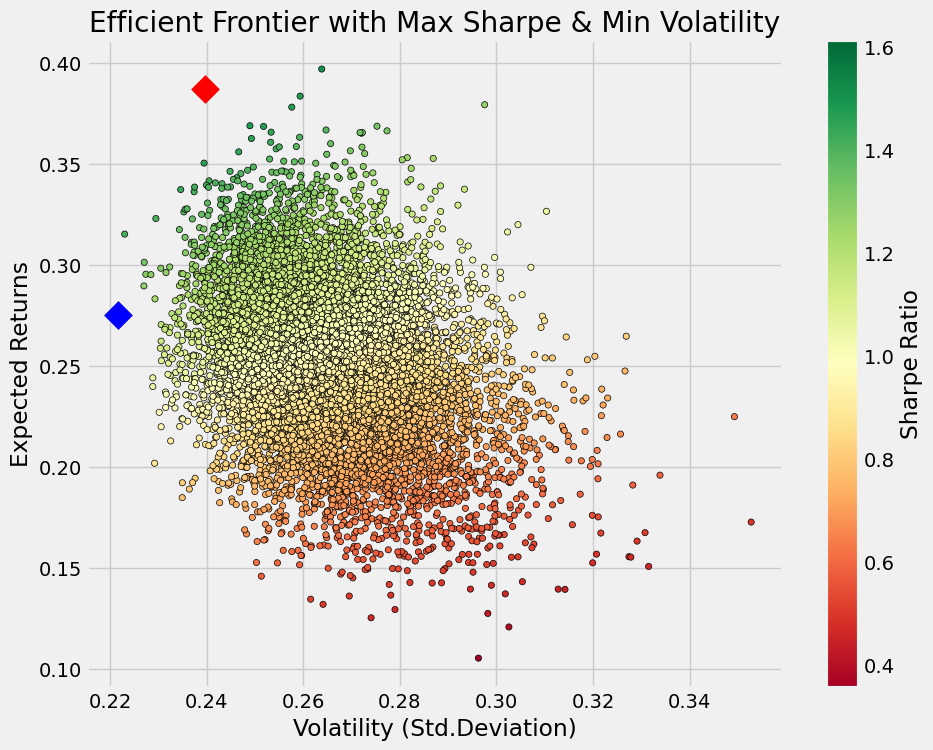

In [12]:
# Finding the Optimal Portfolio
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min volatility values with a scatterplot
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], color='r', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], color='b', marker='D', s=200)
plt.xlabel('Volatility (Std.Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier with Max Sharpe & Min Volatility')
plt.show()



In [13]:
# Additional Details
r_ef = pd.concat([min_variance_port.T, sharpe_portfolio.T], axis=1)
r_ef.columns = ['Min Risk Adjusted Values', 'Max Risk Adjusted Values']
print(r_ef)
 

               Min Risk Adjusted Values  Max Risk Adjusted Values
Returns                        0.275171                  0.387045
Volatility                     0.221742                  0.239735
Sharpe Ratio                   1.240954                  1.614470
INTCWeight                     0.060504                  0.032901
QCOMWeight                     0.104538                  0.055526
MSFTWeight                     0.071819                  0.076772
SONOWeight                     0.034173                  0.120571
1347.HKWeight                  0.011020                  0.071124
0700.HKWeight                  0.053058                  0.018923
NVDAWeight                     0.014646                  0.002514
1810.HKWeight                  0.138995                  0.164470
2454.TWWeight                  0.002172                  0.005310
1211.HKWeight                  0.149677                  0.017786
9888.HKWeight                  0.131094                  0.171664
0992.HKWei

# If I invested 1000 USD last year... what would I have?

In [ ]:
amount_invest = 1000
expected_return = pd.DataFrame(amount_invest * (1+r_ef.iloc[0,:]))
print(""""------------------------------------------------
Expected Returns on portfolio
------------------------------------------------
    """)
print(expected_return.T)
print("")
print(f"""
If I invest {amount_invest} USD on | {dT.index[0]} | I would have...
""")
actual_return = (dT.iloc[dT.shape[0]-1,:] - dT.iloc[0,:])/(dT.iloc[0,:])
beg_price = dT.iloc[0,:]
end_price = dT.iloc[dT.shape[0]-1,:]
percentage_change = (end_price - beg_price)/(beg_price) + 1

w = np.array(r_ef.iloc[3:,0])
money_left = sum(w * percentage_change * amount_invest)

print(f"""------------------------------------------------
Using the Portfolio Weights for Minimum Risk Return Portfolio
        
Starting Balance: ${amount_invest} ; Ending with ${round(money_left,2)}
        
------------------------------------------------
Using the Portfolio Weights Maximum Risk Return Portfolio
        """)
w1 = np.array(r_ef.iloc[3:,1])
money_left1 = sum(w1 * percentage_change * amount_invest)
print(f"""
Starting Balance: ${amount_invest}; Ending with ${round(money_left1,2)}
      """)
        

"------------------------------------------------
Expected Returns on portfolio
------------------------------------------------
    
         Min Risk Adjusted Values  Max Risk Adjusted Values
Returns               1275.171085               1387.044967


If I invest 1000 USD on | 2024-04-11 00:00:00 | I would have...

------------------------------------------------
Using the Portfolio Weights for Minimum Risk Return Portfolio
        
Starting Balance: $1000 ; Ending with $1374.59
        
------------------------------------------------
Using the Portfolio Weights Maximized Risk-Return Portfolio
        

Starting Balance: $1000; Ending with $1361.93
      
